In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
import warnings
warnings.filterwarnings("ignore")

# Read Data and Preprocessing

In [11]:
airline = pd.read_csv('./Data/airline_processed.csv')
airline_train = pd.read_csv('./Data/airline_train.csv')
airline_test = pd.read_csv('./Data/airline_test.csv')
print(airline_train.shape, airline_test.shape)

(95689, 23) (23922, 23)


In [12]:
airline_train = airline_train[~airline_train.isna().any(axis=1)].copy()
airline_test = airline_test[~airline_test.isna().any(axis=1)].copy()
print(airline_train.shape, airline_test.shape)

(95393, 23) (23862, 23)


In [13]:
# encode labels
for i in airline_train.select_dtypes(include=['object']):
    le = LabelEncoder()
    airline_train[i] = le.fit_transform(airline_train[i])
    airline_test[i] = le.fit_transform(airline_test[i])

In [14]:
X_train, y_train = airline_train.iloc[:, 1:], airline_train['satisfaction']
X_test, y_test = airline_test.iloc[:, 1:], airline_test['satisfaction']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95393, 22) (95393,) (23862, 22) (23862,)


# Build Machine Learning Models

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import joblib

In [16]:
# fit models
knn_clf = KNeighborsClassifier()
svm_clf = SVC()
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
xgb_clf = XGBClassifier()

clf_list = [knn_clf, svm_clf, dt_clf, rf_clf, xgb_clf]
clf_name_list = ['KNN', 'SVM', 'DT', 'RF', 'XGB']

for i in range(len(clf_list)):
    clf = clf_list[i]
    clf_name = clf_name_list[i]
    
    start = time.time()
    print(f'Start fitting {clf_name}!')
    clf.fit(X_train, y_train)
    
    end = time.time()
    duration = end - start
    minutes = int(duration // 60)
    seconds = round(duration % 60)
    
    print('Fitting {} done! Spent {}:{}.'.format(
        clf_name, str(minutes).rjust(2, '0'), str(seconds).rjust(2, '0')))
    print('-------------------------------------------')

Start fitting KNN!
Fitting KNN done! Spent 00:00.
-------------------------------------------
Start fitting SVM!
Fitting SVM done! Spent 08:06.
-------------------------------------------
Start fitting DT!
Fitting DT done! Spent 00:00.
-------------------------------------------
Start fitting RF!
Fitting RF done! Spent 00:06.
-------------------------------------------
Start fitting XGB!
Fitting XGB done! Spent 00:02.
-------------------------------------------


In [34]:
# save the models
for clf, clf_name in zip(clf_list, clf_name_list):
    joblib.dump(clf, f'./Models/{clf_name}.pkl')

In [32]:
# report metrics
metrics_df = pd.DataFrame(columns=['Model', 'Metrics', 'Result'])

for clf, clf_name in zip(clf_list, clf_name_list):
    # do predictions
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    # calculate accuracy
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    # calculate sensitivity and specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    # calculate AUC score
    auc = roc_auc_score(y_test, y_pred_test)
    
    # print the metrics and save them to metrics_df
    print('Model:', clf_name)
    print('Acc train: {}\t Acc test: {}\t Sensitivity: {}\t Specificity: {}\t AUC: {}'.format(
        round(acc_train, 4), round(acc_test, 4), round(sensitivity, 4), round(specificity, 4), round(auc, 4)))
    print('-------------------------------------------------------------------------------------------------')
    metrics_one_model = pd.DataFrame({
        'Model': [clf_name] * 4,
        'Metrics': ['Accuracy', 'Sensitivity', 'Specificity', 'AUC Score'],
        'Result': [acc_test, sensitivity, specificity, auc]
    })
    metrics_df = pd.concat([metrics_df, metrics_one_model]).copy()

Model: KNN
Acc train: 0.8202	 Acc test: 0.714	 Sensitivity: 0.7659	 Specificity: 0.6529	 AUC: 0.7094
-------------------------------------------------------------------------------------------------
Model: SVM
Acc train: 0.612	 Acc test: 0.6116	 Sensitivity: 0.5683	 Specificity: 0.6626	 AUC: 0.6154
-------------------------------------------------------------------------------------------------
Model: DT
Acc train: 1.0	 Acc test: 0.9379	 Sensitivity: 0.9453	 Specificity: 0.9291	 AUC: 0.9372
-------------------------------------------------------------------------------------------------
Model: RF
Acc train: 1.0	 Acc test: 0.9578	 Sensitivity: 0.9532	 Specificity: 0.9631	 AUC: 0.9582
-------------------------------------------------------------------------------------------------
Model: XGB
Acc train: 0.9709	 Acc test: 0.9576	 Sensitivity: 0.9534	 Specificity: 0.9625	 AUC: 0.958
-------------------------------------------------------------------------------------------------


In [35]:
# add metrics of logistic and probit models to metrics_df
# the results are calculated by R (glm_logistic_probit.R)
metrics_logistic = pd.DataFrame({
    'Model': ['Logistic'] * 4,
    'Metrics': ['Accuracy', 'Sensitivity', 'Specificity', 'AUC Score'],
    'Result': [0.8777, 0.8927, 0.8600, 0.951]
})
metrics_probit = pd.DataFrame({
    'Model': ['Probit'] * 4,
    'Metrics': ['Accuracy', 'Sensitivity', 'Specificity', 'AUC Score'],
    'Result': [0.863, 0.8851, 0.8370, 0.939]
})
metrics_df = pd.concat([metrics_logistic, metrics_probit, metrics_df]).copy()
metrics_df.reset_index(drop=True, inplace=True)

In [67]:
# save metric_df
metrics_df.to_excel('./Code_outputs/model_metrics.xlsx', index=False)

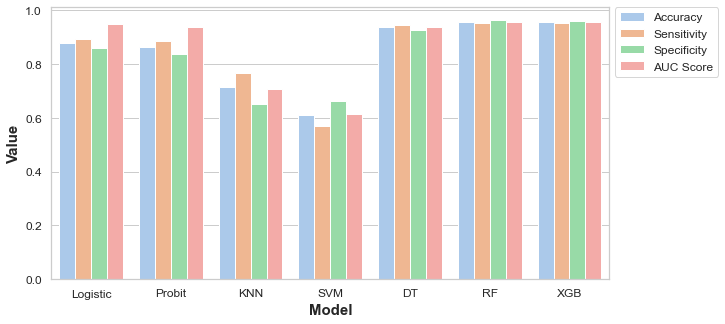

In [48]:
# plot the metrics into a bar chart
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid", palette="pastel")
sns.barplot(data=metrics_df, x='Model', y='Result', hue='Metrics', ax=ax)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12, bbox_to_anchor=(1.01, 1), borderaxespad=0)
ax.set_xlabel('Model', fontsize=15, weight='bold')
ax.set_ylabel('Value', fontsize=15, weight='bold')

plt.savefig('./Figures/model_metrics.png', dpi=300, bbox_inches='tight')

# Random Forest Feature Selection

In [52]:
rf_feature_names = list(X_train.columns)
rf_feature_importances = rf_clf.feature_importances_
std = np.std([rf_clf.feature_importances_ for tree in rf_clf.estimators_], axis=0)

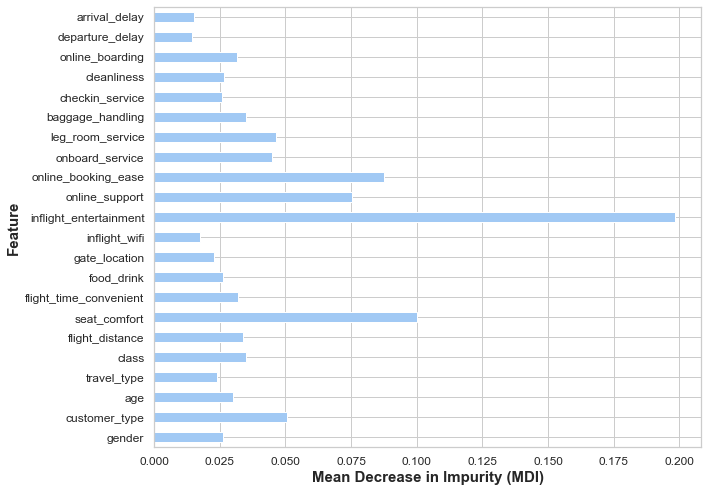

In [66]:
forest_importances = pd.Series(rf_feature_importances, index=rf_feature_names)

fig, ax = plt.subplots(figsize=(10, 7))
forest_importances.plot.barh(yerr=std, ax=ax)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('Mean Decrease in Impurity (MDI)', fontsize=15, weight='bold')
ax.set_ylabel('Feature', fontsize=15, weight='bold')
fig.tight_layout()

plt.savefig('./Figures/rf_importance.png', dpi=300, bbox_inches='tight')